In [1]:
import numpy as np
from numpy import random
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
import umap

In [2]:
from prosstt import simulation as sim
from prosstt import tree
from prosstt import sim_utils as sut

In [3]:
random.seed(42) # truly random

# Preparation

Define a simple single bifurcation tree. We will use this as the underlying biological truth, and will utilise it for sanity checks. We won't bother with non-informative genes to keep this simple, may revisit later.

In [4]:
num_brpoints = 1

# sample the parameters randomly:
G = random.randint(100, 1001)
gene_scale = np.exp(sp.stats.norm.rvs(loc=0.7, scale=1, size=G))

alpha = np.exp(random.normal(loc=np.log(0.2), scale=np.log(1.5), size=G))
beta = np.exp(random.normal(loc=np.log(1), scale=np.log(1.5), size=G)) + 1

num_branches = 2 * num_brpoints + 1
top = tree.Tree.gen_random_topology(num_brpoints)

branches = np.unique(np.array(top).flatten())
time = {b: 50 for b in branches}

t = tree.Tree(topology=top, time=time, num_branches=num_branches, G=G)

Ms = {}
uMs, Ws, H = sim.simulate_lineage(t, a=0.05, intra_branch_tol=0)
gene_scale = sut.simulate_base_gene_exp(t, uMs)
Ms = {}
for branch in t.branches:
    Ms[branch] = np.exp(uMs[branch]) * gene_scale
t.add_genes(Ms)

/Users/papadopoulos/miniconda3/envs/py3k/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [5]:
t.branch_times()

defaultdict(list, {0: [0, 49], 1: [50, 99], 2: [50, 99]})

Sample the tree at three points to create three populations of cells that should be distinguishable from each other:

In [6]:
X, pseudotime, branches, scalings = sim.sample_pseudotime_series(t, [150, 300], [15, 65], 0.1,
                                                                 alpha=alpha, beta=beta)

Define some helper functions:

In [7]:
def calc_cpm(expr_mat):
    """
    Divide each cell by its library size and multiply with 10^6
    """
    norm = np.sum(expr_mat, axis=1)
    return (X.T / norm).T * 1e6

def calc_mean(expr_mat):
    """
    Divide each cell by its library size and multiply with the average library size
    """
    norm = np.sum(expr_mat, axis=1)
    return (X.T / norm * np.mean(norm)).T


def log_umap(expr_mat, pc_comps=10, normalise=None):
    """
    Log-transform the data, calculate PCA and then use components for UMAP.
    """
    if normalise == "cpm":
        normalised = calc_cpm(expr_mat)
    elif normalise == "mean":
        normalised = calc_mean(expr_mat)
    elif normalise is None:
        normalised = expr_mat
    else:
        print("'normalise' argument unacceptable.")
        raise ValueError

    pca = PCA(n_components=10)
    pca.fit(np.log(normalised.T+1))
    reducer = umap.UMAP()
    return reducer.fit_transform(pca.components_.T)

Run a log-transform, PCA & UMAP on the raw data. We only have informative genes so this should work:

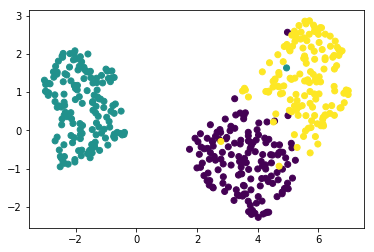

In [8]:
test = log_umap(X)

fig, ax = plt.subplots()
ax.scatter(test[:, 0], test[:, 1], c=branches)

Convert UMIs to CPM and retry. Should be a bit clearer than raw.

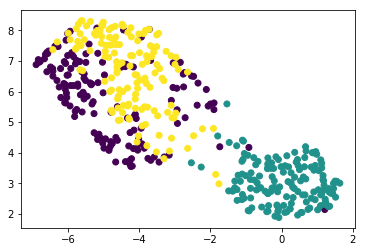

In [9]:
test = log_umap(X, normalise="cpm")

fig, ax = plt.subplots()
ax.scatter(test[:, 0], test[:, 1], c=branches);

Yikes. Try with normalising to the average instead:

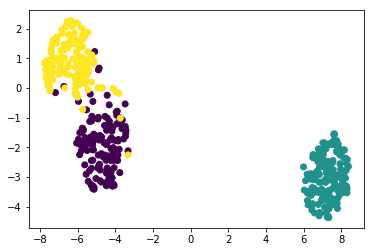

In [10]:
test = log_umap(X, normalise="mean")

fig, ax = plt.subplots()
ax.scatter(test[:, 0], test[:, 1], c=branches);

For future reference, separate the three UMI datasets:

In [19]:
umi_a = X[branches == 0]
umi_b = X[branches == 1]
umi_c = X[branches == 2]

# Create pseudo-bulk datasets

Make three pseudo-bulk datasets from the three groups and normalise to CPM to simulate bulk RNA-seq datasets of known cell types:

In [11]:
cpm = calc_cpm(X)

cpm_a = cpm[branches == 0]
cpm_b = cpm[branches == 1]
cpm_c = cpm[branches == 2]

bulk_a = np.mean(cpm_a, axis=0)
bulk_b = np.mean(cpm_b, axis=0)
bulk_c = np.mean(cpm_c, axis=0)

Let's see how well the pseudo-bulks correlate with the true single cell data for each cluster:

In [12]:
cor_a = np.array([sp.stats.pearsonr(x, bulk_a)[0] for x in X])
cor_b = np.array([sp.stats.pearsonr(x, bulk_b)[0] for x in X])
cor_c = np.array([sp.stats.pearsonr(x, bulk_c)[0] for x in X])

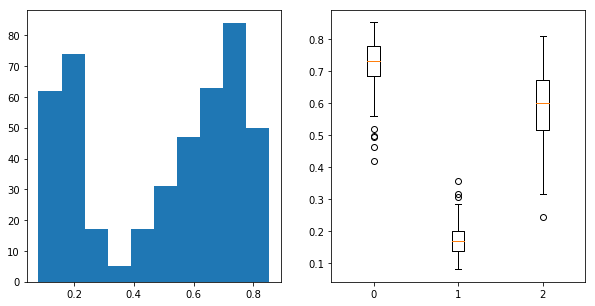

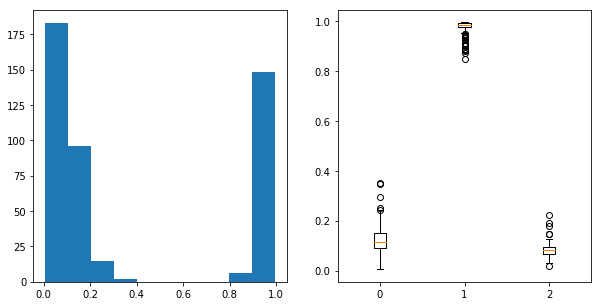

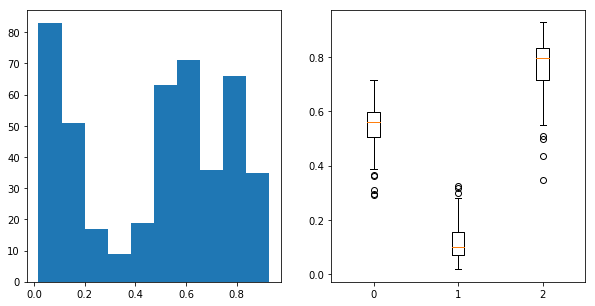

In [13]:
for correlation in [cor_a, cor_b, cor_c]:
    fig, ax = plt.subplots(ncols=2)
    fig.set_size_inches(10, 5)
    ax[0].hist(correlation)
    for br in np.unique(branches):
        ax[1].boxplot(correlation[branches==br], positions=[br])
    ax[1].set_xlim(-0.5, 2.5)
    ax[1].set_xticks([0, 1, 2])
    ax[1].set_xticklabels([0, 1, 2])

We can see clearly where each pseudo-bulk set comes from in the correlation profiles.

# Learn UMI simulation parameters from CPM-normalised single cell

We will use PROSSTT's functions to estimate variance parameters and library size distributions from CPM data. To do that, we need to rescale the CPM-normalised data to the UMI expression range. To do that, we will divide by $10^6$ and multiply with the average library size in the corresponding single cell dataset.

In [14]:
def bulk_cpm_to_umi(bulk, single_cell):
    """
    Rescale the bulk CPM-normalised expression data to the mean of the corresponding single-cell dataset.
    """
    library_size = np.sum(single_cell, axis=1)
    return bulk / 1e6 * np.mean(library_size)

In [22]:
pseudo_umi_a = bulk_cpm_to_umi(bulk_a, umi_a)
pseudo_umi_b = bulk_cpm_to_umi(bulk_b, umi_b)
pseudo_umi_c = bulk_cpm_to_umi(bulk_c, umi_c)

In [23]:
?sut.learn_data_summary

Signature: sut.learn_data_summary(cell_stats, gene_stats, relative_means)
Docstring:
Learns hyperparameters from gene and cell summaries of a real dataset. The
simulated dataset with these hyperparameters will have similar summary
statistics with the input dataset.

Parameters
----------
cell_stats: Series
    Each column is a cell. Contains at minimum the rows:
    - "total": sum of all UMIs in each cell.
    - "zeros": count of genes with 0 reported UMIs in each cell.
gene_stats: Series
    Each column is a gene. Contains at minimum the rows:
    - "means": average expression of each gene over the dataset
    - "var": variance of each gene over the dataset
    - "zeros": count of cells with 0 reported UMIs for each gene
relative_means: Series
    Relative mean expression for all genes on every lineage tree branch

Returns
-------
scale parameters
    Mean and variance of the library size distribution
average alpha
    The average alpha hyperparameter for gene variance
average beta
  

In [32]:
def summarise_data(expr_mat):
    """
    Calculates simple cell and gene attributes. Assumes that the
    expression matrix does not include empty cells or unexpressed genes.
    
    Parameters
    ----------
        expr_mat: numpy ndarray
            The (N, G) UMI expression matrix of N cells with G genes each.
    
    Returns
    -------
        cell_stats: pandas DataFame
            Each column is a cell. Contains at minimum the rows:
            - "total": sum of all UMIs in each cell.
            - "zeros": count of genes with 0 reported UMIs in each cell.
        gene_stats: pandas DataFrame
            Each column is a gene. Contains at minimum the rows:
            - "means": average expression of each gene over the dataset
            - "var": variance of each gene over the dataset
            - "zeros": count of cells with 0 reported UMIs for each gene
    """
    total = np.sum(expr_mat, axis=1)
    cell_zeros = np.sum(expr_mat == 0, axis=1)
    gene_means = np.mean(expr_mat, axis=0)
    gene_var = np.var(expr_mat, axis=0)
    gene_zeros = np.sum(expr_mat == 0, axis=0)
    
    cell_stats = pd.DataFrame({"total": total,
                               "zeros": cell_zeros})
    gene_stats = pd.DataFrame({"means": gene_means,
                               "var": gene_var,
                               "zeros": gene_zeros})
    
    return cell_stats, gene_stats

In [33]:
cell_a, gene_a = summarise_data(umi_a)

PROSSTT is made to simulate trees, but to get around this we can simulate a tree with minimal branch length:

In [39]:
gene_stats = gene_a

In [47]:
np.sum(np.sum(X, axis=0) == 0)

4

In [44]:
np.sum(gene_stats['var']>0)

198

In [40]:
static_top = [[0,1]]

static_branches = [0, 1]
static_time = {b: 1 for b in branches}
static_G = np.sum((gene_stats['means'] > 0) & (gene_stats['var'] > 0))
static_t = tree.Tree(topology=static_top,
                     G=static_G,
                     time=static_time,
                     num_branches=2,
                     branch_points=0,
                     modules=2)

uMs, Ws, Hs = sim.simulate_lineage(t, intra_branch_tol=-1, inter_branch_tol=0)

/Users/papadopoulos/miniconda3/envs/py3k/lib/python3.7/site-packages/prosstt/simulation.py:154: UserWarning: No argument 'a' specified in kwargs: using gamma and a=0.04
  "No argument 'a' specified in kwargs: using gamma and a=0.04", UserWarning)
/Users/papadopoulos/miniconda3/envs/py3k/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
